# Validation

This document shows how the shading calculations using the ``twoaxistracking`` package compare to existing methods found in the literature. Specifically, the annual shading loss is calculated for nine different field layouts and compared with the values presented in Cumpston and Pye (2014).

Import necessary packages:

In [1]:
import pandas as pd
import numpy as np
from shapely import geometry
import twoaxistracking

## Definition of collector geometry

The study by Cumpston and Pye (2014) simulated shading for a circular aperture. The study made no distinction between gross and aperture area, i.e., the two geometries were assumed to be the same.

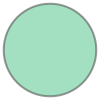

In [2]:
radius = np.sqrt(1/np.pi)  # radius for a circle with an area of 1
collector_geometry = geometry.Point(0,0).buffer(radius)

collector_geometry

<br>

## Reference dataset
The simulations carried out in the reference study were based on the 1976 irradiance dataset from Barstow.

A stringent quality-control of this dataset was carried out as described in the [Reference irradiance dataset](reference_dataset.ipynb) section. This step was necessary as the dataset contained several periods of erroneous data, e.g., irradiance at night and periods with unfeasible irradiance levels.

Load the quality-controlled dataset:

In [3]:
filename = '../../../data/barstow_1976_irradiance_data_quality_controlled.csv'
df = pd.read_csv(filename, index_col=0, parse_dates=[0])

df.head()  # print the first five rows of the dataframe

,ghi,dni,dhi_calc,temp_air,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,dni_extra
time,,,,,,,,,,
1976-01-01 00:15:00-08:00,0.88,0.94,0.88,-1.59,167.092519,167.092519,-77.092519,-77.092519,25.278534,1413.981805
1976-01-01 00:30:00-08:00,0.00,0.94,0.00,-1.94,165.467857,165.467857,-75.467857,-75.467857,38.153710,1413.981805
1976-01-01 00:45:00-08:00,0.88,1.88,0.88,-2.36,163.355080,163.355080,-73.355080,-73.355080,48.333521,1413.981805
1976-01-01 01:00:00-08:00,0.00,0.94,0.00,-2.50,160.917391,160.917391,-70.917391,-70.917391,56.311453,1413.981805
1976-01-01 01:15:00-08:00,0.88,0.00,0.88,-2.78,158.265917,158.265917,-68.265917,-68.265917,62.652770,1413.981805


<br>

Furthermore, it is important to note that the reference study only performed simulations "for solar elevation angles greater than 10°".

Therefore, a new column of the direct normal irradiance (DNI) is derived where the irradiance below 10° elevation is set to zero.

In [4]:
df['dni>10deg'] = df.loc[df['elevation']>10, 'dni']
df['dni>10deg'] = df['dni>10deg'].fillna(0)

<br>

## Field layouts

Cumpston and Pye (2010) provided the annual shading loss (ASL) for nine different field layouts (GCR ranging from 0.1 to 0.9). The field layout parameters and their annual shading loss were:

In [5]:
dfc = pd.DataFrame(
    columns=['gcr', 'aspect_ratio', 'rotation', 'offset', 'asl_cumpston'],
    data=[
        [0.1, 2.3, 0.0, 0.0, 0.04],
        [0.2, 1.61, 0.0, 0.0, 1.53],
        [0.3, 1.11, 1.0, -0.5, 4.50],
        [0.4, 1.0, 0.0, -0.5, 8.14],
        [0.5, np.sqrt(3)/2, 0.0, -0.5, 12.4],
        [0.6, np.sqrt(3)/2, 0.0, -0.5, 17.2],
        [0.7, np.sqrt(3)/2, 0.0, -0.5, 22.3],
        [0.8, np.sqrt(3)/2, 89.0, -0.5, 27.6],
        [0.9, np.sqrt(3)/2, 167.0, -0.5, 33.1]])

dfc.round(2)

,gcr,aspect_ratio,rotation,offset,asl_cumpston
0,0.1,2.30,0.0,0.0,0.04
1,0.2,1.61,0.0,0.0,1.53
2,0.3,1.11,1.0,-0.5,4.50
3,0.4,1.00,0.0,-0.5,8.14
4,0.5,0.87,0.0,-0.5,12.40
5,0.6,0.87,0.0,-0.5,17.20
6,0.7,0.87,0.0,-0.5,22.30
7,0.8,0.87,89.0,-0.5,27.60
8,0.9,0.87,167.0,-0.5,33.10


<br>

For comparison the annual shading loss for the nine field layouts were therefore calculated using the `twoaxistracking` package:

In [6]:
field_parameters = ['gcr', 'aspect_ratio', 'rotation', 'offset']

for index, (gcr, aspect_ratio, rotation, offset) in dfc[field_parameters].iterrows():
    # Define the tracker field for each configuration
    tracker_field = twoaxistracking.TrackerField(
        total_collector_geometry=collector_geometry,
        active_collector_geometry=collector_geometry,
        neighbor_order=2,
        gcr=gcr,
        aspect_ratio=aspect_ratio,
        rotation=rotation,
        offset=offset)
    
    # Calculate shaded fraction for each timestamp
    df['shaded_fraction'] = tracker_field.get_shaded_fraction(df['elevation'], df['azimuth'])

    # Calculate annual shading loss
    dfc.loc[index, 'asl_twoaxistracking'] = (df['shaded_fraction'].multiply(df['dni>10deg'], axis='rows').sum() / 
        df['dni>10deg'].sum())*100

C:\Users\arajen\Documents\GitHub\twoaxistracking\twoaxistracking\layout.py:176: RuntimeWarning: invalid value encountered in arcsin
  (tracker_distance * np.cos(delta_gamma_rad)))) + relative_slope


<br>

### Comparison of annual shading loss
The annual shading loss (ASL) presented in Cumpston and Pye (2014) and those calculated using the `twoaxistracking` package are shown below. The deviations between the shading fractions are presented both in absolute and relative terms.

In [10]:
# Limit asl_twoaxistracking to three significant figures and two decimal places
dfc['asl_twoaxistracking'] = dfc['asl_twoaxistracking'].\
    apply(lambda s: f"{s:.3g}").astype(float).round(2)
# Calculate absolute and relatieve deviation
dfc['absolute_deviation'] = (dfc['asl_twoaxistracking'] - dfc['asl_cumpston'])
dfc['relative_deviation'] = (dfc['asl_twoaxistracking'] - dfc['asl_cumpston']).\
    divide(dfc['asl_cumpston']).multiply(100)

result_columns = ['asl_cumpston', 'asl_twoaxistracking', 'absolute_deviation', 'relative_deviation']
dfc.set_index('gcr')[result_columns].round(2).map(lambda s: f"{s:.2f} %")

,asl_cumpston,asl_twoaxistracking,absolute_deviation,relative_deviation
gcr,,,,
0.1,0.04 %,0.04 %,0.00 %,0.00 %
0.2,1.53 %,1.51 %,-0.02 %,-1.31 %
0.3,4.50 %,4.49 %,-0.01 %,-0.22 %
0.4,8.14 %,8.09 %,-0.05 %,-0.61 %
0.5,12.40 %,12.30 %,-0.10 %,-0.81 %
0.6,17.20 %,17.10 %,-0.10 %,-0.58 %
0.7,22.30 %,22.20 %,-0.10 %,-0.45 %
0.8,27.60 %,27.40 %,-0.20 %,-0.72 %
0.9,33.10 %,32.90 %,-0.20 %,-0.60 %


The comparison above shows that the differences between the annual shading losses are very low (always lower than 1.3%). The discrepancies are believed to be due to minor differences in the quality control procedure applied to reference data.

The reference study (Cumpston and Pye, 2014) utilized the shading calculation algorithm developed by Meller (2010). Meller's algorithm has previously been compared to results from Pons & Dugan (1984).

## References

[Cumpston, J. and Pye, J., 2014. Shading and land use in regularly-spaced sun-tracking collectors. Sol. Energy 108, 199–209.](https://doi.org/10.1016/j.solener.2014.06.012)

[Meller, Y., 2010. Analytically calculating shading in regular arrays of sun-pointing collectors. Sol. Energy 84, 1967–1974. ](https://doi.org/10.1016/j.solener.2010.08.006)

[Pons, R.L., Dugan, A.F., 1984. The effect of concentrator field layout on the performance of point-focus distributed receiver systems. J. Sol. Energy Eng. Trans. ASME 106, 35–38.](https://doi.org/10.1115/1.3267559)